# Amazon Fine Food Reviews Analysis - Naive Bayes


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.

In this assignment I perform,

1. All the Data cleaning and Text Preprocessing steps on the Amazon reviews.

Once the data cleaning is done, we perform the following steps:
2. First we have to sort the data using timestamp and then split Train and Test data using Time based Splitting (70% - train data and 30% - test data).
3. Next apply Naive Bayes on BoW and TFIDF techniques
4. Find right alpha using 10-fold Cross Validation
5. Plot ROC curve and find AUC value.
6. Find Test accuracy and test error and compute confusion matrix (TPR, FPR, FNR, TNR)
7. Compute classification report features like accuracy, precision, recall, f1-score.
8. Get the Feature Importance (important features) for positive class and negative class. Feature importance in case of Amazon reviews dataset is, finding out which words are more prominent/have more probability/more often found for positive labels and for negative labels/review


# 1. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [2]:
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from tqdm import tqdm
import os

In [3]:
# Loading the data
# using the SQLite Table to read data.
con = sqlite3.connect('I:\Python\database.sqlite') 
#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) 


# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(5)

Number of data points in our data (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


#  2. Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It was necessary to remove duplicates in order to get unbiased results for the analysis of the data. Hence in order to reduce redundancy it's better to eliminate the rows having same parameters.

The method used to perform deduplication is that, we first sort the data according to ProductId and then just keep the first similar product review and delete the others. This method ensures that there is only one representative for each product.

In [4]:
#Sorting data according to ProductId in ascending order
sorted_data = filtered_data.sort_values('ProductId', axis = 0, ascending = True, inplace=False, kind='quicksort', na_position='last')

#Dropping duplicates. It says that find duplicates with {'UserId', 'ProfileName', 'Time', 'Text'} values same. Then it is a duplicate
# By using drop_duplicate function we just keep the first product Id of the duplicates and remove the remaining.
final_data = sorted_data.drop_duplicates(subset = {'UserId', 'ProfileName', 'Time', 'Text'}, keep = 'first', inplace = False)

# Now it prints total reviews after removing duplicates.
print('Total number of reviews in the dataframe after removing duplicates :', final_data.shape)


Total number of reviews in the dataframe after removing duplicates : (364173, 10)


In [6]:
# HelpfulnessNumerator should always be less than HelpfulnessDenominator. 
# So check if any reviews have HelpfulnessNumerator greater than HelpfulnessDenominator and remove them
final_data = final_data[final_data.HelpfulnessNumerator <= final_data.HelpfulnessDenominator]

final_data.shape

(364171, 10)

In [7]:
#Checking to see how much % of data still remains

(final_data['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25852107399194

In [8]:
# Lets see how many total reviews left
print(final_data.shape)

#How many positive and negative reviews are present in the dataset?
final_data['Score'].value_counts()

(364171, 10)


positive    307061
negative     57110
Name: Score, dtype: int64

#### Observation:-
From the above output we can see that there are many positive reviews and fewer negative reviews.

#  3. Text Preprocessing :- Stemming, Stop-word removal and Lemmatization

Now that we have finished deduplication, our data requires some preprocessing before we go on further with analysis and perform Naive Bayes on Featurizations.

1. By removing stop-words, BoW vector will be small and more meaningful
2. Lemmatization is a process of breaking a sentence into words. It is language and context dependent

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the words to lowercase
6. Remove Stopwords
7. Finally Stemming the words which are related, to their stem form/root/base form (Snowball stemmer is used as it is obsereved to be better than Porter Stemming)

After which we collect the words used to describe positive and negative reviews

In [9]:
# find sentences containing HTML tags
import re
i=0;
for sentence in final_data['Text'].values:
    if (len(re.findall('<.*?>', sentence))):
        print(i)
        print(sentence)
        break;
    i += 1;

6
I set aside at least an hour each day to read to my son (3 y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we've read it perpetually and he loves it.<br /><br />First, this book taught him the months of the year.<br /><br />Second, it's a pleasure to read. Well suited to 1.5 y/o old to 4+.<br /><br />Very few children's books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak's best.


In [10]:
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
# nltk - Natural Language Processing Toolkit
# re - regular expression
import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

#prints all the set of stopwords in english
stop = set(stopwords.words('english')) 
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer, created a variable sno

# function to clean the word of any html-tags and replaces the sentence in angular braces <-----> with one space ' '
def cleanhtml(sentence): 
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence) # sub-substitute
    return cleantext
#function to clean the word of any punctuation or special characters
def cleanpunc(sentence): 
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence) #replace with empty string
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print(stop)
print('\n','length of stopwords set' , len(stop))
print('************************************')
# Stemming - Converting the words into their base word or stem word or root word
print(sno.stem('tasty'))

{'yourselves', 'doesn', "hasn't", 'wouldn', 'now', 'was', 'some', 'and', 'they', 'herself', 'its', 'both', 'by', 'until', 'me', 'what', 'against', 'again', 'm', "hadn't", 'those', 'each', "doesn't", 'such', 'itself', "should've", 'hasn', 'can', 'has', 'so', 'that', 'about', 'hadn', 'all', "isn't", 'will', 'their', 've', 'up', 'ours', 'don', 'for', "you're", 'is', "you've", 'before', 'a', 'just', 'these', 'where', 'yourself', 'the', 'him', "you'd", 'does', 'few', 'mightn', "don't", "it's", 'won', 'you', 'no', 'on', 'more', 'aren', 'at', 'into', 's', 'mustn', "needn't", 'this', 'ourselves', 'needn', 'i', 'who', 't', "wasn't", 'but', 'there', 'when', 'she', 'isn', 'why', 'o', 'to', "you'll", 'himself', 'with', 'ma', "weren't", 'ain', 'any', 'here', 'couldn', 'be', 'hers', 'it', 'were', 'own', 'd', 'haven', "won't", 'theirs', 'above', 'of', 'did', 'my', 'do', 'further', 'other', 'shan', 'same', 'off', 'then', 'under', 'between', "mustn't", 'after', 'while', 'shouldn', 'once', 'your', "have

In [11]:
# step-by-step code to perform all pre-processing steps and to clean the text data

i=0
str1=' '
final_string=[]  # creating final string which is list of final strings after all the processing
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sentence in final_data['Text'].values:
    filtered_sentence=[]
    #print(sent); 
    sentence=cleanhtml(sentence) # remove HTMl tags
    for w in sentence.split():  # splitting the words
        for cleaned_words in cleanpunc(w).split():  # cleaning the punctuation for each word
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):  # checking if the words are alphanumeri and len is >2
                if(cleaned_words.lower() not in stop):  # converting words into lowercase and removing stopwords
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')  # performing stemming on the words
                    filtered_sentence.append(s)  # after all the above processing steps, final sentence is stored in this
                    if (final_data['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all  positive words 
                    if(final_data['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all negative words
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) # joining the filtered sentence to construct the final string of cleaned words
    #print("***********************************************************************")

    final_string.append(str1)
    i+=1


In [12]:
# store final_data table into an SQlLite table for future.
conn = sqlite3.connect('final_data.sqlite')
c=conn.cursor()
conn.text_factory = str
final_data.to_sql('Reviews', conn,  schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)


In [13]:
#adding a column of CleanedText and storing all the strings of every review obtained after pre-processing steps
final_data['CleanedText']=final_string 
final_data['CleanedText']=final_data['CleanedText'].str.decode("utf-8")
final_data.shape
final_data.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,positive,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",grew read sendak book watch realli rosi movi i...
138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,positive,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,fun way children learn month year learn poem t...


In [14]:
print(final_data['Score'].value_counts())

positive    307061
negative     57110
Name: Score, dtype: int64


# 4. Sample the data from the Dataset

In [15]:
# Taking equal sample of negative and positive reviews each 50000, total 100,000 datapoints
positive_pts = final_data[final_data['Score'] == 'positive'].sample(n=50000)
negative_pts = final_data[final_data['Score'] == 'negative'].sample(n=50000)

# Concatenating both positive and negative points
total_score = pd.concat([positive_pts, negative_pts])
total_score.shape


(100000, 11)

## [4.1] Time Based Splitting

Generally we do random splitting of entire dataset into train, test, cross validate data. With this method we may not get correct accuracy everytime. With time products change and reviews for the product also change, hence with random splitting we may not get best value/accuracy.

But for Amazon Food Reviews Dataset Time based splitting is better than Random splittng. We can perform Time based splitting only when we have time feature in our dataset. Train data is used to find Nearest Neighbours, Cross Validate data is used to find best 'K' and Test data is used to find accuracy and we train a model on all these.

So Time based splitting gives more accuracy than random splitting, even on the future data when data changes with time. It's preferable to do Time based splitting when time is available.

1. For each review in the dataset there is a timestamp. In Time based splitting, we first sort all the data in the dataset in increasing order(ascending) of time.
2. Now split 70% of data into Train data and remaining 30% of data into test data.


In [16]:
# sorting data using time
total_score['Time'] = pd.to_datetime(total_score['Time'])
total_score = total_score.sort_values(by = 'Time', ascending = True)

In [17]:
# display top 5 rows
total_score.head(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,positive,1970-01-01 00:00:00.940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,rememb see show air televis year ago child sis...
417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,positive,1970-01-01 00:00:00.944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,beetlejuic well written movi everyth excel act...
346041,374343,B00004CI84,A1B2IZU1JLZA6,Wes,19,23,negative,1970-01-01 00:00:00.948240000,WARNING: CLAMSHELL EDITION IS EDITED TV VERSION,"I, myself always enjoyed this movie, it's very...",alway enjoy movi funni entertain didnt hesit p...
346141,374450,B00004CI84,ACJR7EQF9S6FP,Jeremy Robertson,2,3,positive,1970-01-01 00:00:00.951523200,Bettlejuice...Bettlejuice...BETTLEJUICE!,What happens when you say his name three times...,happen say name three time michael keaten star...
346094,374400,B00004CI84,A2DEE7F9XKP3ZR,jerome,0,3,positive,1970-01-01 00:00:00.959990400,Research - Beatlejuice video - French version,I'm getting crazy.I'm looking for Beatlejuice ...,get crazi look beatlejuic french version video...


### Splitting data into Train and Test data

In [52]:
# loading libraries

from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn import cross_validation
from sklearn.random_projection import sparse_random_matrix
from scipy.sparse import csr_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

In [19]:
# splitting the data into train, test data
X = total_score['CleanedText']
Y = total_score['Score']
# X = total data, Y = class labels, X_test and Y_test are test data set of 30%
# Total score is splitted into Train and test data with 70-30 ratio

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=0)

print('X_train, Y_train', X_train.shape, Y_train.shape)
print('X_test, Y_test', X_test.shape, Y_test.shape)

X_train, Y_train (70000,) (70000,)
X_test, Y_test (30000,) (30000,)


# Featurizations

## 5. Bag of Words (BoW)


1. It is one of the simple technique to convert text to vector.
2. Constructs a dictionary with set of all the unique words in the reviews.
3. Next construct a vector of size 'd' for d-unique words. Each index corresponds to one word in the dictionary.
4. Each word is different dimension in d-dim vector and each cell in vector corresponds to number of times the corresponding word occurs in review.
5. There are different BoW. One is Binary BoW - it says that, instead of specifying the count of number of occurances, it will specify whether the word occurs or not. This is also called boolean BoW.
6. BoW can be said as number of differing words. BoW is applied after all the preprocessing and data cleaning steps. It just says whether a word is present or not in the text. We get set of words


In [43]:
# BoW
# Creating a variable count_vect of CountVectorizer type and inititalizing it.
count_vect = CountVectorizer() #in scikit-learn

# X_train and X_test data is converted vector and is stored in X_train_bow and X_test_bow
X_train_bow = count_vect.fit_transform(X_train)
X_test_bow = count_vect.transform(X_test)

# sparse matrix - most of the values of any row in a matrix are zero.Such matrices are called sparse matrix and row in the matrix is sparse vector
# The more sparse a matrix is, the more efficient is sparse matrix representation technique
print("the type of count vectorizer ", type(X_train_bow))# gets the type of X_train_bow which is a matrix
print("the type of count vectorizer ", type(X_test_bow))# gets the type of X_test_bow which is a matrix

# gets the shape of the matrix
print(X_train_bow.get_shape()) 
print(X_test_bow.get_shape()) 

print("the number of unique words are ", X_train_bow.get_shape()[1])
print("the number of unique words are ", X_test_bow.get_shape()[1])


the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
(70000, 32479)
(30000, 32479)
the number of unique words are  32479
the number of unique words are  32479


### [5.1] Bayes Theorem and Naive Bayes:


1. Bayes theorem is one of the most fundamental theorem in probability. It is simple, elegant and useful theorem. ML technique Naive Bayes is named after Bayes theorem.
2. In Naive Bayes, Naive means conditional independence of each feature pairs, which is an assumption. It says, features are conditionally independent of each other.
3. Naive Bayes is popular technique on text data, for text classification. In this, the train data is divided into positive and negative class and probability of each word/data point belonging to a particular is computed which are likelihoods. Once we computer likelihoods and priors, then we can achieve the task of classification of reviews into positive and negative reviews.
4. Naive Bayes is considered as a baseline model against other models for text classification problems.
5. 'Alpha' in Laplace smoothing determines underfit or overfit. As alpha chances we will have high bias or high variance.
6. If 'alpha' is very large then we get underfitting problem ---> high bias and if 'alpha' is 0 then we get overfitting problem ---> high variance.
7. We can find right 'alpha'(hyper parameter) using simple cross validation (or) 10-fold cross validation. Hyper parameters help us decide which is the right model.

Naive Bayes is impacted by imbalanced data in 2 ways. 1. Priors 2. likelihood ratios in case of imbalanced data:-

Because of class priors the majority class has an advantage over minority class, when we are comparing probabilities of positive and negative class, which is not correct. So to solve this problem we can do upsampling or downsampling and drop the probabilities.

When we get a outlier at test time then we can perform laplace smoothing on it.

If a word occurs very few times in train data which we can consider as a outlier, then one solution is, we can discard that particular word from train data. Another solution is to use laplace smoothing to the probability of that word.

If the random variable distribution/likelihood probabilities takes 2 values (0 and 1) then it is called Bernoulli Naive Bayes. If the distribution of random variable is multinomial then it is called Multinomial Naive Bayes.

When we assume likelihood probabilities are gaussian then it is Gaussian Naive Bayes.

Conditional Independence is the big assumption Naive Bayes is making.

In this assignent I am using MultinomialNB as it can be used for the features with discrete values like word counts for text classification or ratings ranging 1 to 5. In text learning we have the count of each word to predict the class or label.

The multinomial distribution is an appropriate distribution for the likelihood, and thus multinomial Naive Bayes is appropriate. 

### [5.2] Performing 10-fold CV on BoW using f1-score as metric

In [45]:
# creating a list of alpha values range for hyper parameter tuning 
myList = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
scores = 0
# empty lists that will hold cv scores and train scores
cv_scores = []
train_scores = []
for i in myList:
    naive_bayes = MultinomialNB(alpha = i)
    # performing 10-fold cross validation on whole train data with f1_macro as metric as it calculates mean values and result
    # is stored into scores.
    scores = cross_val_score(naive_bayes, X_train_bow, Y_train, cv=10, scoring='f1_macro')
    # score is same as predict. It predicts model accuracy on train data. 
    # First fit the train data or train the train data and predict accuracy using score()
    scores_train = naive_bayes.fit(X_train_bow, Y_train).score(X_train_bow, Y_train)
    
    cv_scores.append(scores.mean()) # Average score of 10 folds is stored in cv_scores
    train_scores.append(scores_train)
    

#### Plotting f1-score v/s Alpha values for CV and Train data


The optimal alpha is 10.


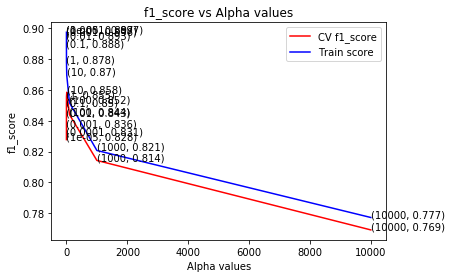

The CV f1-score for each alpha value is :  [0.828 0.831 0.836 0.843 0.85  0.855 0.858 0.844 0.814 0.769]
the Train score for each alpha value is :  [0.897 0.897 0.896 0.893 0.888 0.878 0.87  0.852 0.821 0.777]


In [46]:

# determining best alpha with maximum CV f1-score
optimal_alpha = myList[cv_scores.index(max(cv_scores))] 
print('\nThe optimal alpha is %d.' % optimal_alpha)

# plot f1-score vs alpha
plt.plot(myList, cv_scores, 'r', label='CV f1_score')
plt.plot(myList, train_scores, 'b', label='Train score')
plt.legend(loc='upper right')

for xy in zip(myList, np.round(cv_scores,3)):  # for each point (x=myList, y= mse)
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')  # annotate with (myList, mse)
    
for xy in zip(myList, np.round(train_scores,3)):  # for each point (x=myList, y= mse)
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')  # annotate with (myList, mse)
    
plt.title("f1_score vs Alpha values")
plt.xlabel('Alpha values')
plt.ylabel('f1_score')
plt.show()

print("The CV f1-score for each alpha value is : ", np.round(cv_scores,3))

print("the Train score for each alpha value is : ", np.round(train_scores,3))



#### Observation:-
From the above plot, we can know optimal alpha with maximum CV f1-score. As alpha = 10 has maximum f1-score of 0.858 than other alpha values, it is considered as optimal alpha.

The model accuracy on Train data is high when alpha values are low. As the alpha increases, the train data accuracy falls.

### [5.3] Finding accuracy on test data using f1-score

In [47]:
# instantiate learning model i = optimal_alpha
from sklearn.metrics import f1_score
naive_bayes_optimal = MultinomialNB(alpha = optimal_alpha)

# fitting the model
naive_bayes_optimal.fit(X_train_bow, Y_train)

# predict the response
pred_bow = naive_bayes_optimal.predict(X_test_bow)

# evaluate accuracy. Using f1_score as metric to measure accuracy
test_f1_bow = f1_score(Y_test, pred_bow, pos_label = 'positive', average = 'binary') * float(100)
print('\nThe test f1-score of the naive bayes classifier for alpha = %d is %f%%' % (optimal_alpha, test_f1_bow))


The test f1-score of the naive bayes classifier for alpha = 10 is 85.073735%


In [48]:
# Finding test error
test_error_bow = (1 - f1_score(Y_test, pred_bow, pos_label = 'positive', average = 'binary')) 
print("Test Error for Naive Bayes BoW is %.3f%%" % (test_error_bow))

Test Error for Naive Bayes BoW is 0.149%


### [5.4] Plotting ROC curve and finding AUC score for BoW

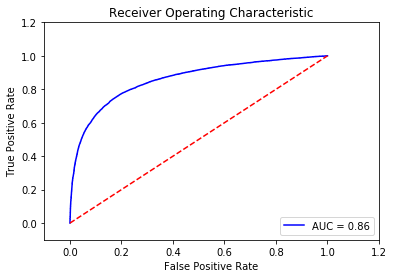

In [49]:
# ROC curve and AUC for BoW
from sklearn.metrics import roc_curve, auc
# Predicting the probabilities of test data as ROC curve needs probabilities to plot
Y_prob = naive_bayes.fit(X_train_bow, Y_train).predict_proba(X_test_bow)
# Giving actual values(Y_test) and predicted probabilities Y_prob
# we need to calculate the fpr and tpr for all thresholds of the classification 
fpr, tpr, thresholds = roc_curve(Y_test, Y_prob[:, 1], pos_label = 'positive')
# We calculate the AUC (Area Under Curve)
roc_auc = auc(fpr, tpr)
    
# Plot FPR (on x-axis) v/s TPR (on y-axis)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#### Observation:-
From the ROC curve of BoW, we can know AUC score is 0.86, which shows that the classifier is working well and predicts correctly.

### [5.5] Confusion matrix for BoW

In [50]:
# Using confusion matrix as a another metric to measure accuracy
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test, pred_bow) # finding confusion matrix between true data and predicted data
print(cm)

[[12699  2261]
 [ 2233 12807]]


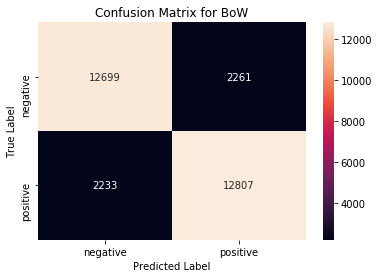

In [51]:
# plot confusion matrix for BoW
class_label = ["negative", "positive"] # create a class label for columns and rows
cm = confusion_matrix(Y_test, pred_bow) 
dataframe_cm = pd.DataFrame(cm, index = class_label, columns = class_label) # create a dataframe to plot confusion matrix
# A heatmap is a two-dimensional graphical representation of data in seaborn,
# where the individual values in a matrix are represented with colors.
sns.heatmap(dataframe_cm, annot = True, fmt = "d") # annot=true means, write the data value in each cell
plt.title("Confusion Matrix for BoW")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

#### Observations:-

A Confusion matrix is a table that is often used to describe the performance of the classification model on a set of test data. It is also one of the metric to measure accuracy of the model.

A confusion matrix is a summary of prediction results on a classification problem. The number of correct and incorrect predictions are summarized with count values and broken down by each class. The confusion matrix shows how the classification model is confused when it makes predictions.

The above confusion matrix is didvided into 2 classes positive and negative with True values and predicted values.

1.  TN - 12699 , FP - 2261

    FN - 2233  , TP - 12807

    where

2. TN - True negative, True value is negative, and is predicted value is negative. 
3. FP - False positive, True value is negative, but is predicted as positive. 
4. FN - False negative, True value is positive, but is predicted as negative 
5. TP - True positive, True value is positive, and is predicted value is positive.


6. There are total of 30000 points being tested against the model. Out of all values, the classifier/model predicted points as positive 15,068 times and negative 14,932 times.
7. But in true values(test data), the positive points are 15,040 and negative points are 14,960.
8. The diagonal values (12699 negative points, 12807 positive points) in the confusion matrix are correctly predicted values by the classifier.

#### Finding TPR, FPR, TNR, FNR values

1. TPR tells, when it's actually yes and how often does classifier predict yes

   TPR = TP/(TP+FN) = 12807/15040 = 0.8515. TPR also known as Recall


2. FPR tells, when it's actually no, how often does classifier predict yes

   FPR = FP/(FP+TN) = 2261/14960 = 0.1511


3. TNR tells, when it's actually no, how often does classifier predict no

   TNR = TN/(TN+FP) = 12699/14960 = 0.8488


4. FNR tells, When it's actually yes, how often does it predict no

   FNR = FN/(FN+TP) = 2233/15040 = 0.1484

### [5.6] Classification report for BoW:-



1.  Classification Rate/Accuracy:

    Accuracy = (TP + TN) / (TP + TN + FP + FN)


2.  Recall:- It tells, when the points are positive and how often they are predicted positive.

    Recall = TP / (TP + FN)


3.  Precision:- It tells, when the model predicted positive and how often is it correct.

    Precision = TP / (TP + FP)


4.  f1-score = (2 Recall Precision) / (Recall + Presision)

    Support is the total number of points in each class (positive and negative)


In [53]:
# calculate the classification report for BoW
from sklearn.metrics import classification_report 
 
print('Accuracy Score:', accuracy_score(Y_test, pred_bow)) 
print('Report:')
print(classification_report(Y_test, pred_bow)) 


Accuracy Score: 0.8502
Report:
             precision    recall  f1-score   support

   negative       0.85      0.85      0.85     14960
   positive       0.85      0.85      0.85     15040

avg / total       0.85      0.85      0.85     30000



#### Observation:-
In case of BoW Naive Bayes, accuracy, f1-score, precision all gave same score of 85% accuracy for alpha = 10. 

### [5.7] Feature Importance for BoW

To find feature Importance, first sort all the words based on its probability score, where top words have more probability of its occurance, that means it occurs lot of times and so its probability is high. So we can say that, words which have highest probability are very informative/useful/important words or features in determining that data point/word Wi belongs to a particular class (positve or negative).

So for positive class or negative class, we have to find words with highest value of probabilities, as they are most informative/important features or words for determining whether the text/sentence belongs to positive class or negative class.

In Naive Bayes we can get feature importance directly from the model.

In [54]:
features = count_vect.get_feature_names()
# creating a dataframe 
df = pd.DataFrame(naive_bayes.feature_log_prob_,columns=features)
df_transposed = df.T

In [55]:
bow_pos_features = df_transposed[1].sort_values(ascending = False)[0:10] # Positive
bow_neg_features = df_transposed[0].sort_values(ascending = False)[0:10] # Negative


In [56]:
# Top 10 positive features
bow_pos_features

like      -9.436979
tast      -9.498941
good      -9.578288
flavor    -9.580995
love      -9.601731
use       -9.605639
great     -9.618470
one       -9.647386
product   -9.677456
tri       -9.694080
Name: 1, dtype: float64

In [57]:
# Top 10 negative features
bow_neg_features

tast      -9.250977
like      -9.297570
product   -9.389721
one       -9.585631
flavor    -9.599060
would     -9.643013
tri       -9.663731
use       -9.729573
good      -9.738214
coffe     -9.743477
Name: 0, dtype: float64

## 6. TF-IDF

In [58]:
# TF-IDF
# in Scikit-learn
# tf_idf_vect is a variable created 
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2)) # 1=unigrams, 2=bi-grams

# 'final_tf_idf' is the sparse matrix in which all of the tf-idf values are stored. 
# fit_transform is a function
X_train_tfidf = tf_idf_vect.fit_transform(X_train)
X_test_tfidf = tf_idf_vect.transform(X_test)

print("the type of TFIDF vectorizer ",type(X_train_tfidf))
print("the type of TFIDF vectorizer ",type(X_test_tfidf))

print(X_train_tfidf.get_shape())
print(X_test_tfidf.get_shape())

print("the number of unique words ", X_train_tfidf.get_shape()[1])
print("the number of unique words ", X_test_tfidf.get_shape()[1])


the type of TFIDF vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the type of TFIDF vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
(70000, 1028526)
(30000, 1028526)
the number of unique words  1028526
the number of unique words  1028526


In [59]:
# get_feature_names() function is used to get feature names and all are stored in a variable called 'features'
features = tf_idf_vect.get_feature_names()
len(features)

1028526

In [60]:
print("some sample features(unique words in the corpus) are:")
features[50000:50010]

some sample features(unique words in the corpus) are:


['attach review',
 'attach round',
 'attach screw',
 'attach second',
 'attach secur',
 'attach ship',
 'attach slide',
 'attach sometim',
 'attach spout',
 'attach spray']

In [61]:
def top_tfidf_feats(row, features, top_n=20):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]   # argsort sorts the top 20 tf-idf words for a given review
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

# vector 1 corresponding to review 1 and converting it into a numpy array and giving all feature values and prints the top 20 tf-idf values
top_tfidf = top_tfidf_feats(X_train_tfidf[1,:].toarray()[0],features,20)

In [62]:
top_tfidf

,feature,tfidf
0,clearanc shelv,0.211443
1,your black,0.211443
2,packag target,0.211443
3,target clearanc,0.211443
4,also stock,0.211443
5,real british,0.203964
6,shelv glad,0.203964
7,british way,0.203964
8,drinker stuff,0.203964
9,stock tea,0.198658


### [6.1] Performing 10-fold CV on TF-IDF using f1-score as metric

In [66]:
# creating a list of alpha values range for hyper parameter tuning 
myList = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
scores = 0
# empty lists that will hold cv scores and train scores
cv_scores = []
train_scores = []
for i in myList:
    naive_bayes = MultinomialNB(alpha = i)
    # performing 10-fold cross validation on whole train data with f1_macro as metric as it calculates mean values and result
    # is stored into scores.
    scores = cross_val_score(naive_bayes, X_train_tfidf, Y_train, cv=10, scoring='f1_macro')
    # score is same as predict. It predicts model accuracy on train data. 
    # First fit the train data or train the train data and predict accuracy using score()
    scores_train = naive_bayes.fit(X_train_tfidf, Y_train).score(X_train_tfidf, Y_train)
    
    cv_scores.append(scores.mean()) # Average score of 10 folds is stored in cv_scores
    train_scores.append(scores_train)
    

#### Plotting f1-score v/s Alpha values for CV and Train data


The optimal alpha is 1.


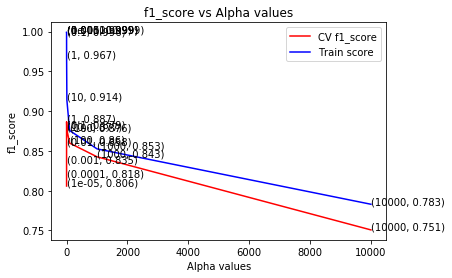

The CV f1-score for each alpha value is :  [0.806 0.818 0.835 0.858 0.879 0.887 0.877 0.86  0.843 0.751]
the Train score for each alpha value is :  [0.999 0.999 0.999 0.999 0.996 0.967 0.914 0.876 0.853 0.783]


In [67]:
# determining best alpha with maximum CV f1-score
optimal_alpha = myList[cv_scores.index(max(cv_scores))] 
print('\nThe optimal alpha is %d.' % optimal_alpha)

# plot f1-score vs alpha
plt.plot(myList, cv_scores, 'r', label='CV f1_score')
plt.plot(myList, train_scores, 'b', label='Train score')
plt.legend(loc='upper right')

for xy in zip(myList, np.round(cv_scores,3)):  # for each point (x=myList, y= mse)
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')  # annotate with (myList, mse)
    
for xy in zip(myList, np.round(train_scores,3)):  # for each point (x=myList, y= mse)
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')  # annotate with (myList, mse)
    
plt.title("f1_score vs Alpha values")
plt.xlabel('Alpha values')
plt.ylabel('f1_score')
plt.show()

print("The CV f1-score for each alpha value is : ", np.round(cv_scores,3))

print("the Train score for each alpha value is : ", np.round(train_scores,3))



#### Observation:-

From the above plot, we can know optimal alpha with maximum CV f1-score. As alpha = 1 has maximum f1-score of 0.887 than other alpha values, it is considered as optimal alpha.

The model accuracy on Train data is high when alpha values are low. As the alpha increases, the train data accuracy falls.


### [6.2] Finding accuracy on test data using f1-score

In [69]:
# Findind test accuracy using f1-score for TF-IDF
# instantiate learning model i = optimal_alpha
from sklearn.metrics import f1_score
naive_bayes_optimal = MultinomialNB(alpha = optimal_alpha)

# fitting the model
naive_bayes_optimal.fit(X_train_tfidf, Y_train)

# predict the response
pred_tfidf = naive_bayes_optimal.predict(X_test_tfidf)

# evaluate accuracy. Using f1_score as metric to measure accuracy
test_f1_tfidf = f1_score(Y_test, pred_tfidf, pos_label = 'positive', average = 'binary') * float(100)
print('\nThe test f1-score of the naive bayes classifier for alpha = %d is %f%%' % (optimal_alpha, test_f1_tfidf))


The test f1-score of the naive bayes classifier for alpha = 1 is 88.110304%


In [70]:
# Finding test error
test_error_tfidf = (1 - f1_score(Y_test, pred_tfidf, pos_label = 'positive', average = 'binary')) 
print("Test Error for Naive Bayes TF-IDF is %.3f%%" % (test_error_tfidf))

Test Error for Naive Bayes TF-IDF is 0.119%


### [6.3] Plotting ROC curve and finding AUC score for TF-IDF

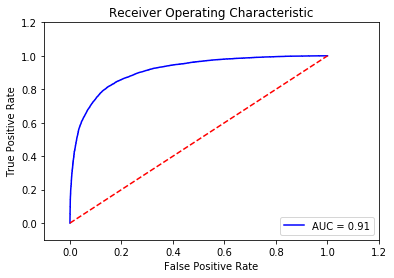

In [71]:
# ROC curve and AUC for TF-IDF
from sklearn.metrics import roc_curve, auc
# Predicting the probabilities of test data as ROC curve needs probabilities to plot
Y_prob = naive_bayes.fit(X_train_tfidf, Y_train).predict_proba(X_test_tfidf)
# Giving actual values(Y_test) and predicted probabilities Y_prob
# we need to calculate the fpr and tpr for all thresholds of the classification 
fpr, tpr, thresholds = roc_curve(Y_test, Y_prob[:, 1], pos_label = 'positive')
# We calculate the AUC (Area Under Curve)
roc_auc = auc(fpr, tpr)
    
# Plot FPR (on x-axis) v/s TPR (on y-axis)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#### Observation:-
From the ROC curve of TF-IDF, we can know AUC score is 0.91, which shows that the classifier is working well and predicts correctly.

### [6.4] Confusion matrix for TF-IDF

In [72]:
# Using confusion matrix as a another metric to measure accuracy
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test, pred_tfidf) # finding confusion matrix between true data and predicted data
print(cm)

[[13202  1758]
 [ 1812 13228]]


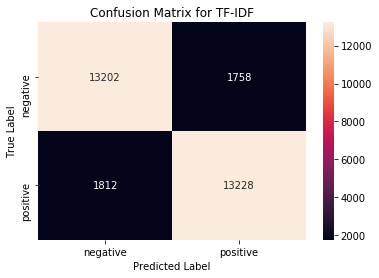

In [73]:
# plot confusion matrix for TF-IDF
class_label = ["negative", "positive"] # create a class label for columns and rows
cm = confusion_matrix(Y_test, pred_tfidf) 
dataframe_cm = pd.DataFrame(cm, index = class_label, columns = class_label) # create a dataframe to plot confusion matrix
# A heatmap is a two-dimensional graphical representation of data in seaborn,
# where the individual values in a matrix are represented with colors.
sns.heatmap(dataframe_cm, annot = True, fmt = "d") # annot=true means, write the data value in each cell
plt.title("Confusion Matrix for TF-IDF")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

#### Observation:-

A Confusion matrix is a table that is often used to describe the performance of the classification model on a set of test data. It is also one of the metric to measure accuracy of the model.

A confusion matrix is a summary of prediction results on a classification problem. The number of correct and incorrect predictions are summarized with count values and broken down by each class. The confusion matrix shows how the classification model is confused when it makes predictions.

The above confusion matrix is didvided into 2 classes positive and negative with True values and predicted values.

1. TN - 13202 , FP - 1758

    FN - 1812 , TP - 13228

    where

2. TN - True negative, True value is negative, and is predicted value is negative.
3. FP - False positive, True value is negative, but is predicted as positive.
4. FN - False negative, True value is positive, but is predicted as negative
5. TP - True positive, True value is positive, and is predicted value is positive.


6. There are total of 30000 points being tested against the model. Out of all values, the classifier/model predicted points as positive 14,986 times and negative 15,014 times.
7. But in true values(test data), the positive points are 15,040 and negative points are 14,960.
8. The diagonal values (13202 negative points, 13228 positive points) in the confusion matrix are correctly predicted values by the classifier.


#### Finding TPR, FPR, TNR, FNR values

1.  TPR tells, when it's actually yes and how often does classifier predict yes

    TPR = TP/(TP+FN) = 13228/15040 = 0.8795. TRP also known as Recall


2.  FPR tells, when it's actually no, how often does classifier predict yes

    FPR = FP/(FP+TN) = 1758/14960 = 0.1175


3.  TNR tells, when it's actually no, how often does classifier predict no

    TNR = TN/(TN+FP) = 13202/14960 = 0.8824


4.  FNR tells, When it's actually yes, how often does it predict no

    FNR = FN/(FN+TP) = 1812/15040 = 0.1204



### [6.5] Classification report for TF-IDF:-

1.  Classification Rate/Accuracy:

    Accuracy = (TP + TN) / (TP + TN + FP + FN)


2.  Recall:- It tells, when the points are positive and how often they are predicted positive.

    Recall = TP / (TP + FN)


3.  Precision:- It tells, when the model predicted positive and how often is it correct.

    Precision = TP / (TP + FP)


4.  f1-score = (2 Recall Precision) / (Recall + Presision)

    Support is the total number of points in each class (positive and negative)



In [74]:
# calculate the classification report for TF-IDF
from sklearn.metrics import classification_report 
 
print('Accuracy Score:', accuracy_score(Y_test, pred_tfidf)) 
print('Report:')
print(classification_report(Y_test, pred_tfidf)) 


Accuracy Score: 0.881
Report:
             precision    recall  f1-score   support

   negative       0.88      0.88      0.88     14960
   positive       0.88      0.88      0.88     15040

avg / total       0.88      0.88      0.88     30000



#### Observation:-
In case of TF-IDF Naive Bayes, accuracy, f1-score, precision all gave same score of 88% accuracy for alpha = 1. 

### [6.6] Feature Importance for TF-IDF

To find feature Importance, first sort all the words based on its probability score, where top words have more probability of its occurance, that means it occurs lot of times and so its probability is high. So we can say that, words which have highest probability are very informative/useful/important words or features in determining that data point/word Wi belongs to a particular class (positve or negative).

So for positive class or negative class, we have to find words with highest value of probabilities, as they are most informative/important features or words for determining whether the text/sentence belongs to positive class or negative class.

In Naive Bayes we can get feature importance directly from the model.


In [75]:
features = tf_idf_vect.get_feature_names()
# creating a dataframe 
df = pd.DataFrame(naive_bayes.feature_log_prob_,columns=features)
df_transposed = df.T

In [76]:
tfidf_pos_features = df_transposed[1].sort_values(ascending = False)[0:10] # Positive
tfidf_neg_features = df_transposed[0].sort_values(ascending = False)[0:10] # Negative


In [77]:
# Top 10 positive features
tfidf_pos_features

great     -13.789916
love      -13.791090
good      -13.796380
tea       -13.798080
like      -13.798538
flavor    -13.799346
tast      -13.799426
coffe     -13.801199
use       -13.802921
product   -13.806500
Name: 1, dtype: float64

In [78]:
# Top 10 neagtive features
tfidf_neg_features

tast      -13.780035
like      -13.787959
product   -13.790161
flavor    -13.802703
coffe     -13.803386
would     -13.804629
one       -13.805396
tri       -13.808919
buy       -13.809468
order     -13.810371
Name: 0, dtype: float64

## 7. Models Summarization

In [79]:
from pandas import DataFrame
Naive_Bayes = {'Vectorizer':['BoW', 'TFIDF'], 'Model':['MultinomialNB', 'MultinomialNB'], 'Hyper parameter (Alpha)':['10', '1'], 
               'AUC Score':['0.86','0.91' ], 'Test Accuracy (f1-score)':['85.07%', '88.11%'], 'Test Error':['0.14', '0.11']}


In [80]:
Final_conclusions = DataFrame(Naive_Bayes)
Final_conclusions

,Vectorizer,Model,Hyper parameter (Alpha),AUC Score,Test Accuracy (f1-score),Test Error
0,BoW,MultinomialNB,10,0.86,85.07%,0.14
1,TFIDF,MultinomialNB,1,0.91,88.11%,0.11


## 8. Conclusion:-

1. From the above observations, we can say that for alpha = 1, MultinomialNB on TF-IDF gave more f1-score than BoW and test error is also less for TF-IDF than BoW.
2. AUC score for TF-IDF = 0.91 is better than BoW which is 0.86
3. Overall both the models BoW and TF-IDF are working well on unseen data using MultinomialNB.
4. Naive Bayes is fast training model as compared to KNN model and is giving better AUC and f1-score than KNN.

